In [ ]:
using PyPlot
using FastGaussQuadrature
using QuantumToolbox
# using BenchmarkTools
# using BlockBandedMatrices
using JLD2


plt.rc("text", usetex = true)
plt.rc("text.latex", preamble = raw"\usepackage{amsmath} \usepackage{physics}")
plt.rc("axes", labelpad = 2)
plt.rc("legend", frameon = false)
plt.rc("font", size = 14)
plt.rc("axes", labelsize = 14)
plt.rc("xtick", labelsize = 14)
plt.rc("ytick", labelsize = 14)
plt.rc("legend", fontsize = 13)

# Dispersive Regime

In [2]:
function disp_Dicke_close(ωa, ωb, g)
    if ωb*ωa > 4 * g^2
        return sqrt(1/2 * (ωa^2 + ωb^2 - sqrt((ωa^2 - ωb^2)^2 + 16 * g^2 * ωa * ωb)))
    else
        μ = ωa * ωb/(4 * g^2)
        return sqrt(1/2 * (ωa^2 + ωb^2/μ^2 - sqrt((ωa^2 - ωb^2/μ^2)^2 + 4 * ωa^2 * ωb^2)))
    end
end

function disp_rel_dispersive(ωa, η)
    if η <= ωa/4
        return sqrt(ωa^2 - 4 * η * ωa)
    else
        return sqrt(ωa^2 - ωa^4 / (16 * η^2))
    end
end

function D(ω, ωa, η, γa)
    return ω^2 + 1im * γa * ω - ωa^2 + 4 * η * ωa
end

D (generic function with 1 method)

## Analytical

In [3]:

function coeff_1h_kernel(ω, ωd, ωa, η, γa, ϵ) # kernel of the form 1/(x^2-1) without ω in the numerator
    return 2 * γa * D(ω+ωd, ωa, η, γa) * D(ω-ωd, ωa, η, γa) / (4 * ϵ^2 * ωa^2 * (D(ω+ωd, ωa, η, γa) + D(ω-ωd, ωa, η, γa)) - D(ω, ωa, η, γa) * D(ω+ωd, ωa, η, γa) * D(ω-ωd, ωa, η, γa))
end

function coeffs_1h(ω, ωd, ωa, η, γa, ϵ)
    k = coeff_1h_kernel(ω, ωd, ωa, η, γa, ϵ)
    if ω < 0 || ω > ωd
        return 0.0, 0.0, 0.0
    else
        return -2im * ϵ * ωa * sqrt(ω * (ωd - ω)) / D(ω - ωd, ωa, η, γa) * k,
               1 + 1im * ω * k,
               -2im * ϵ * ωa * sqrt(ω * (ω + ωd)) / D(ω + ωd, ωa, η, γa) * k
    end
end

function vacuum_expectation_1h(ω, ωd, ωa, η, γa, ϵ)
    return abs2(coeffs_1h(ω, ωd, ωa, η, γa, ϵ)[1])
end

function vacuum_expectation_1h_res(ω, ωa, η, γa, ϵ)
    return vacuum_expectation_1h(ω, 2*disp_rel_dispersive(ωa, η), ωa, η, γa, ϵ)
end

function coeffs_linear(ω, ωd, ωa, η, γa, ϵ)
    k = - 2 * γa / D(ω, ωa, η, γa)
    if ω < 0 || ω > ωd
        return 0.0, 0.0, 0.0
    else
        return -2im * ϵ * ωa * sqrt(ω * (ωd - ω)) / D(ω - ωd, ωa, η, γa) * k,
               1 + 1im * ω * k,
               -2im * ϵ * ωa * sqrt(ω * (ω + ωd)) / D(ω + ωd, ωa, η, γa) * k
    end
end

function vacuum_expectation_linear(ω, ωd, ωa, η, γa, ϵ)
    return abs2(coeffs_linear(ω, ωd, ωa, η, γa, ϵ)[1])
end

function vacuum_expectation_linear_res(ω, ωa, η, γa, ϵ)
    return vacuum_expectation_linear(ω, 2*disp_rel_dispersive(ωa, η), ωa, η, γa, ϵ)
end

function photon_flux_1h(n, k, ωd, ωa, η, γa, ϵ)
    x, w = gausslegendre(n)
    return k/2 * dot(w, vacuum_expectation_1h.(k/2 * (x .+ 1), ωd, ωa, η, γa, ϵ))
end

function photon_flux_linear(n, k, ωd, ωa, η, γa, ϵ)
    x, w = gausslegendre(n)
    return k/2 * dot(w, vacuum_expectation_linear.(k/2 * (x .+ 1), ωd, ωa, η, γa, ϵ))
end

function photon_flux_1h_res(n, k, ωa, η, γa, ϵ)
    return photon_flux_1h(n, k, 2*disp_rel_dispersive(ωa, η), ωa, η, γa, ϵ)
end

function photon_flux_linear_res(n, k, ωa, η, γa, ϵ)
    return photon_flux_linear(n, k, 2*disp_rel_dispersive(ωa, η), ωa, η, γa, ϵ)
end

photon_flux_linear_res (generic function with 1 method)

### Photon flux density

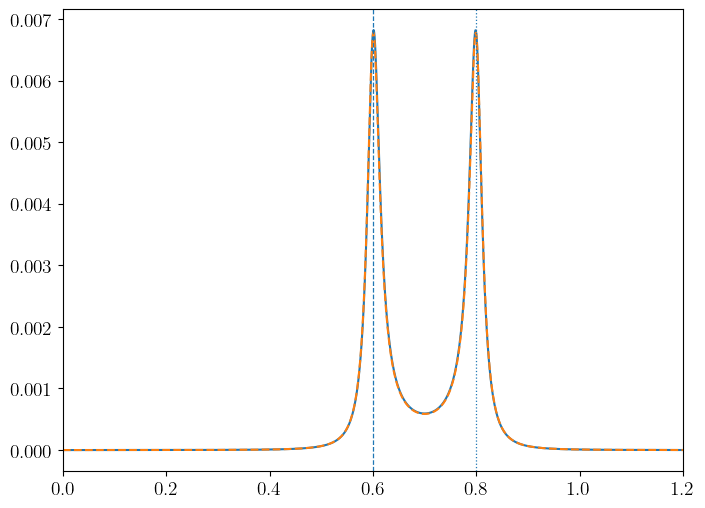

In [4]:
ωa = 1.0
η = 0.16
γa = 0.03
ϵ = 0.005
ωd = 1.4

ω_list = range(0.0, 2, 2000)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(ω_list, [vacuum_expectation_1h(ω, ωd, ωa, η, γa, ϵ) for ω in ω_list])
ax.plot(ω_list, [vacuum_expectation_linear(ω, ωd, ωa, η, γa, ϵ) for ω in ω_list], linestyle="--")

ax.axvline(disp_rel_dispersive(ωa, η), linestyle="--", linewidth=0.9)
ax.axvline(ωd - disp_rel_dispersive(ωa, η), linestyle=":", linewidth=0.9)
ax.set_xlim(0, 2 * disp_rel_dispersive(ωa, η))
;

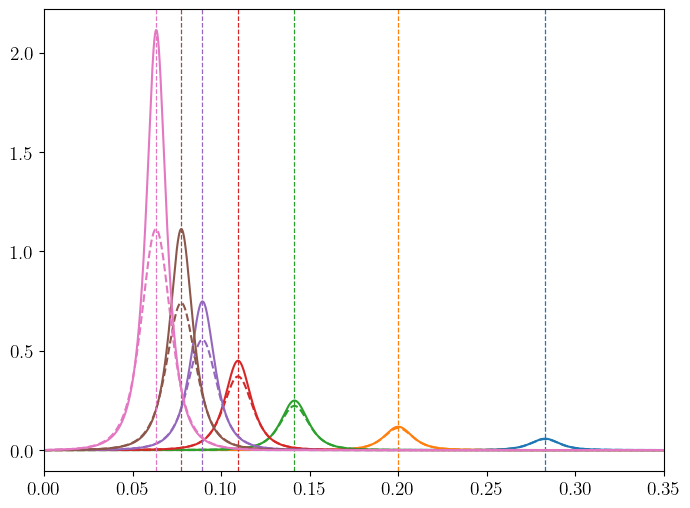

In [5]:
ωa = 1.0
η_list_discreta = [0.23, 0.24, 0.245, 0.247, 0.248, 0.2485, 0.249]
γa = 0.03
ϵ = 0.0005
ωd = 1.2

ω_list = range(0.0, 1.5, 10000)

fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(ω_list, [vacuum_expectation_1h_res(ω, ωa, η, γa, ϵ) for ω in ω_list, η in η_list_discreta])
# ax.plot(ω_list, [vacuum_expectation_linear_res(ω, ωa, η, γa, ϵ) for ω in ω_list, η in η_list_discreta], linestyle="--")

for i in 1:length(η_list_discreta)
    ax.plot(ω_list, [vacuum_expectation_1h_res(ω, ωa, η_list_discreta[i], γa, ϵ) for ω in ω_list], color="C$(i-1)")
    ax.plot(ω_list, [vacuum_expectation_linear_res(ω, ωa, η_list_discreta[i], γa, ϵ) for ω in ω_list], linestyle="--", color="C$(i-1)")
    ax.axvline(disp_rel_dispersive(ωa, η_list_discreta[i]), linestyle="--", linewidth=0.9, color="C$(i-1)")
    # ax.axvline(ωd - disp_rel_dispersive(ωa, η_list_discreta[i]), linestyle=":", linewidth=0.9, color="C$(i-1)")
end

# ax.legend()

ax.set_xlim(0, 0.35)
;

In [6]:
ωa = 1.0
# η = 0.16
γa = 0.03
ϵ = 0.005
ωd = 1.2

ω_list = range(0.0, 2, 1000)
η_list = range(0.0, 0.25 - ϵ, 1000)

harmonic1 = [vacuum_expectation_1h(ω, ωd, ωa, η, γa, ϵ) for ω in ω_list, η in η_list]
harmonic1_res = [vacuum_expectation_1h_res(ω, ωa, η, γa, ϵ) for ω in ω_list, η in η_list]
;

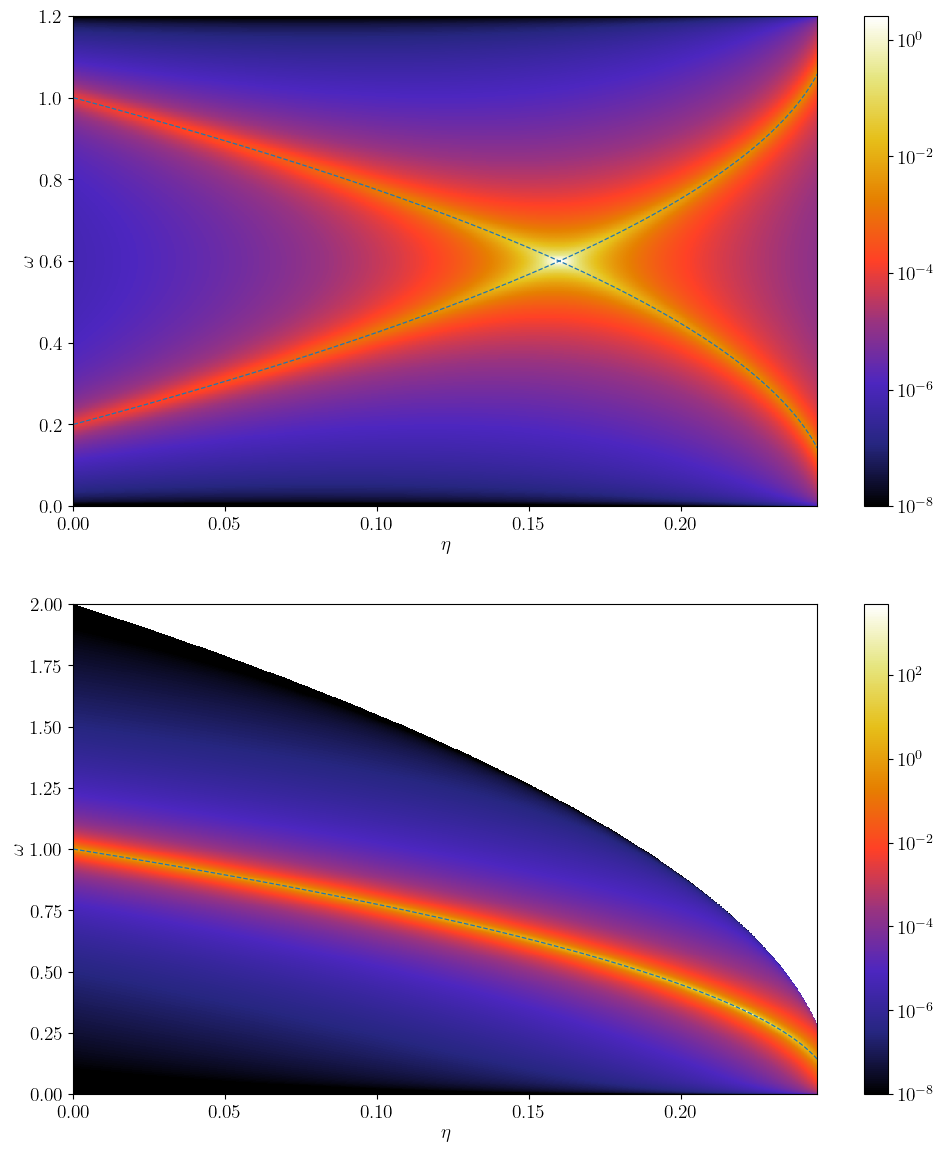

PyObject <matplotlib.colorbar.Colorbar object at 0x7f294285eed0>

In [7]:
LogNorm = PyPlot.matplotlib[:colors][:LogNorm]

fig, ax = plt.subplots(2, 1, figsize = (12, 14))

c1 = ax[1].pcolormesh(η_list, ω_list, harmonic1, cmap="CMRmap", norm=LogNorm(vmin=1e-8, vmax=maximum(harmonic1)))
c2 = ax[2].pcolormesh(η_list, ω_list, harmonic1_res, cmap="CMRmap", norm=LogNorm(vmin=1e-8, vmax=maximum(harmonic1_res)))

ax[1].set_xlim(0, 0.25 - ϵ)
ax[1].set_ylim(0, ωd)
ax[1].set_xlabel(raw"$\eta$")
ax[1].set_ylabel(raw"$\omega$")

ax[2].set_xlim(0, 0.25 - ϵ)
ax[2].set_ylim(ω_list[1], ω_list[end])
ax[2].set_xlabel(raw"$\eta$")
ax[2].set_ylabel(raw"$\omega$")

ax[1].plot(η_list, [disp_rel_dispersive(ωa, η) for η in η_list], color="C0", linestyle="--", linewidth=0.9)
ax[1].plot(η_list, [ωd - disp_rel_dispersive(ωa, η) for η in η_list], color="C0", linestyle="--", linewidth=0.9)

ax[2].plot(η_list, [disp_rel_dispersive(ωa, η) for η in η_list], color="C0", linestyle="--", linewidth=0.9)

fig.colorbar(c1, ax=ax[1])
fig.colorbar(c2, ax=ax[2])

### Photon flux

In [8]:
ωa = 1.0
γa = 0.03
ϵ = 0.001
ωd = 1.2

η_list = range(0.0, 0.25 - ϵ, 1000)

photon_flux_1h_list = zeros(Float64, length(η_list))
photon_flux_linear_list = zeros(Float64, length(η_list))

prog = ProgressBar(length(η_list))
Threads.@threads for i in eachindex(η_list)
    photon_flux_1h_list[i] = photon_flux_1h_res(20000, 2*disp_rel_dispersive(ωa, η_list[i]), ωa, η_list[i], γa, ϵ)
    photon_flux_linear_list[i] = photon_flux_linear_res(20000, 2*disp_rel_dispersive(ωa, η_list[i]), ωa, η_list[i], γa, ϵ)
    next!(prog)
end

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)


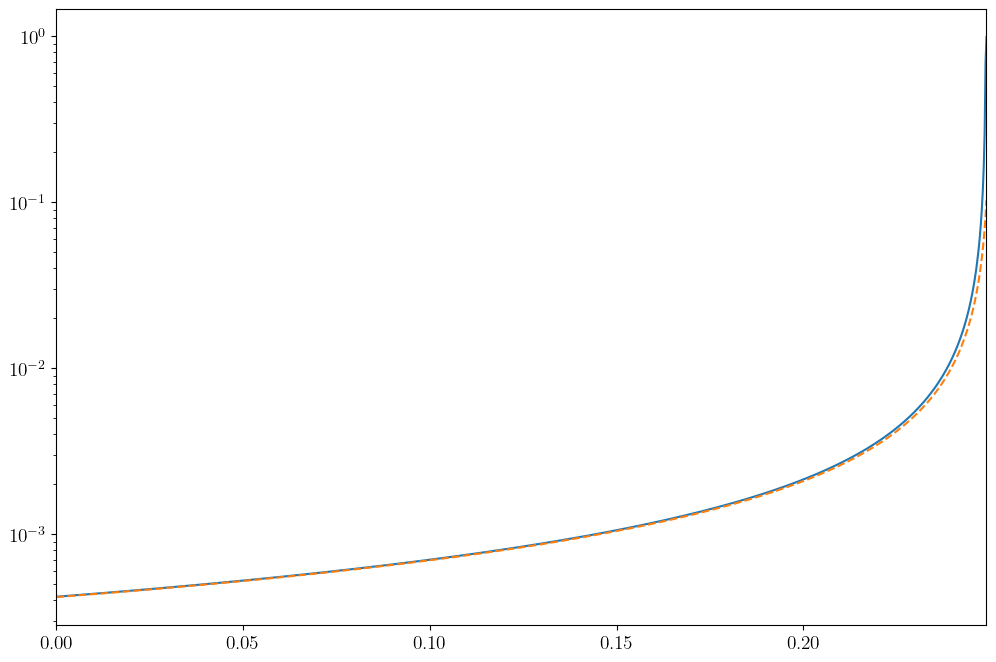

(0.0, 0.249)

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(η_list, photon_flux_1h_list)
ax.plot(η_list, photon_flux_linear_list, linestyle="--")

ax.set_yscale("log")
ax.set_xlim(η_list[1], η_list[end])

In [45]:
ωa = 1.0
γa = 0.01
ϵ = 0.0005
η = 0.249

ωd_list = range(0.01, 1.5, 500)

photon_flux_1h_list_ωd = zeros(Float64, length(ωd_list))
photon_flux_linear_list_ωd = zeros(Float64, length(ωd_list))

prog = ProgressBar(length(ωd_list))
Threads.@threads for i in eachindex(ωd_list)
    photon_flux_1h_list_ωd[i] = photon_flux_1h(20000, 2*disp_rel_dispersive(ωa, η), ωd_list[i], ωa, η, γa, ϵ)
    photon_flux_linear_list_ωd[i] = photon_flux_linear(20000, 2*disp_rel_dispersive(ωa, η), ωd_list[i], ωa, η, γa, ϵ)
    next!(prog)
end

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)


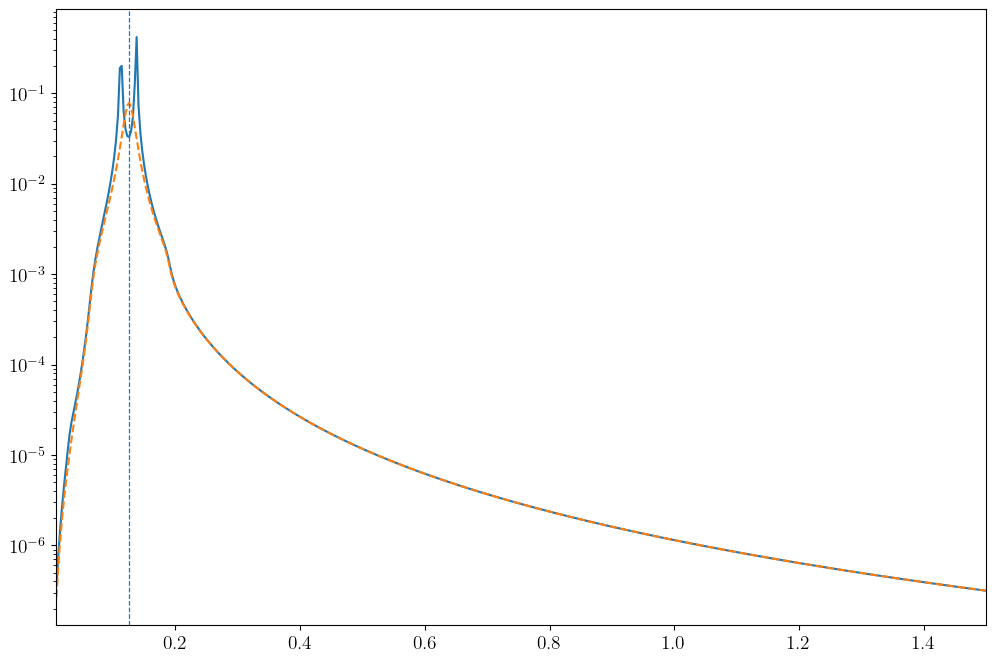

(0.01, 1.5)

In [46]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(ωd_list, photon_flux_1h_list_ωd)
ax.plot(ωd_list, photon_flux_linear_list_ωd, linestyle="--")

ax.axvline(2*disp_rel_dispersive(ωa, η), linestyle="--", linewidth=0.9)

ax.set_yscale("log")
ax.set_xlim(ωd_list[1], ωd_list[end])

In [12]:
ωa = 1.0
γa = 0.03
ϵ = 0.001
ωd = 1.2

η_list = range(0.0, 0.25 - ϵ, 1000)
ωd_list = range(0.01, 1.5, 500)

photon_flux_1h_spectrum = zeros(Float64, length(ωd_list), length(η_list))
photon_flux_linear_spectrum = zeros(Float64, length(ωd_list), length(η_list))

prog = ProgressBar(length(η_list))
Threads.@threads for i in eachindex(η_list)
    photon_flux_1h_spectrum[:, i] = [photon_flux_1h(20000, 2*disp_rel_dispersive(ωa, η_list[i]), ωd, ωa, η_list[i], γa, ϵ) for ωd in ωd_list]
    photon_flux_linear_spectrum[:, i] = [photon_flux_linear(20000, 2*disp_rel_dispersive(ωa, η_list[i]), ωd, ωa, η_list[i], γa, ϵ) for ωd in ωd_list]
    next!(prog)
end

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 50s (ETA: 0h 00m 00s)


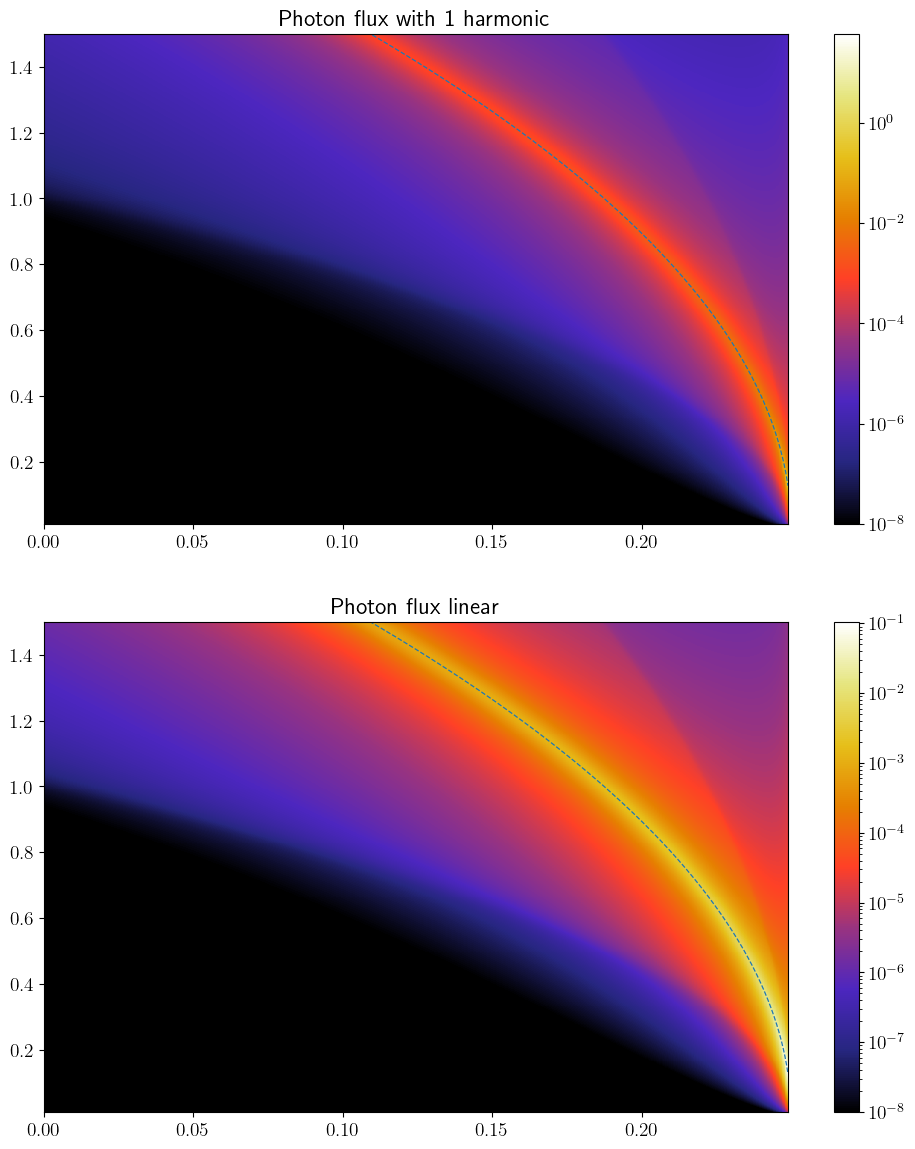

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2924965690>

In [20]:
LogNorm = PyPlot.matplotlib[:colors][:LogNorm]

fig, ax = plt.subplots(2, 1, figsize=(12, 14))

c1 = ax[1].pcolormesh(η_list, ωd_list, photon_flux_1h_spectrum, cmap="CMRmap", norm=LogNorm(vmin=1e-8, vmax=maximum(photon_flux_1h_spectrum)))
cbar1 = fig.colorbar(c1, ax=ax[1])

ax[1].set_xlim(η_list[1], η_list[end])
ax[1].set_ylim(ωd_list[1], ωd_list[end])
ax[1].set_title(raw"Photon flux with 1 harmonic")

ax[1].plot(η_list, [2*disp_rel_dispersive(ωa, η) for η in η_list], color="C0", linestyle="--", linewidth=0.9)


c2 = ax[2].pcolormesh(η_list, ωd_list, photon_flux_linear_spectrum, cmap="CMRmap", norm=LogNorm(vmin=1e-8, vmax=maximum(photon_flux_linear_spectrum)))
cbar2 = fig.colorbar(c2, ax=ax[2])

ax[2].set_xlim(η_list[1], η_list[end])
ax[2].set_ylim(ωd_list[1], ωd_list[end])
ax[2].set_title(raw"Photon flux linear")

ax[2].plot(η_list, [2*disp_rel_dispersive(ωa, η) for η in η_list], color="C0", linestyle="--", linewidth=0.9)

## Numerical Simulations

In [6]:
function M(ω, ωa, η, γa)
    return [ωa - 2*η - 1im*γa/2 - ω   (- 2*η + 1im*γa/2); 2*η + 1im*γa/2     (-ωa + 2*η - 1im*γa/2 - ω)]
end

function Aϵ(ϵ)
    return [ϵ ϵ; -ϵ -ϵ]
end

function TridiagonalMatrix(ω, ωd, ωa, η, γa, ϵ, n)

    A = zeros(ComplexF64, 2*(2*n+1), 2*(2*n+1))
    B = Aϵ(ϵ)
    for i in 1:n-1
        A[2*n+2*i+1:2*n+2*i+2, 2*n+2*i+1:2*n+2*i+2] = M(ω + i*ωd, ωa, η, γa)
        A[2*n+2*i+1:2*n+2*i+2, 2*n+2*i-1:2*n+2*i] = -B
        A[2*n+2*i+1:2*n+2*i+2, 2*n+2*i+3:2*n+2*i+4] = -B

        A[2*n-2*i+1:2*n-2*i+2, 2*n-2*i+1:2*n-2*i+2] = M(ω - i*ωd, ωa, η, γa)
        A[2*n-2*i+1:2*n-2*i+2, 2*n-2*i-1:2*n-2*i] = -B
        A[2*n-2*i+1:2*n-2*i+2, 2*n-2*i+3:2*n-2*i+4] = -B
    end

    A[2*n+1:2*n+2, 2*n+1:2*n+2] = M(ω, ωa, η, γa)
    A[2*n+1:2*n+2, 2*n-1:2*n] = -B
    A[2*n+1:2*n+2, 2*n+3:2*n+4] = -B

    A[4*n+1:4*n+2, 4*n+1:4*n+2] = M(ω + n*ωd, ωa, η, γa)
    A[4*n+1:4*n+2, 4*n-1:4*n] = -B

    A[1:2, 1:2] = M(ω - n*ωd, ωa, η, γa)
    A[1:2, 3:4] = -B

    return A
end

function coeffs_harmonics(ω, ωd, ωa, η, γa, ϵ, n)
    A = inv(TridiagonalMatrix(ω, ωd, ωa, η, γa, ϵ, n))

    coeffs = zeros(ComplexF64, 2*n+1)
    for i in 1:(2*n+1)
        coeffs[i] = 1im * (A[2*n+1, 2*i-1] - A[2*n+1, 2*i] - A[2*n+2, 2*i-1] + A[2*n+2, 2*i]) * γa * sqrt(abs(ω + (i-n-1) * ωd) / ω)
    end
    coeffs[n+1] += 1

    return coeffs
end

function coeffs_harmonics_reduced(ω, ωd, ωa, η, γa, ϵ, n)
    A = inv(TridiagonalMatrix(ω, ωd, ωa, η, γa, ϵ, n))

    coeffs = zeros(ComplexF64, n)
    for i in 1:n
        coeffs[i] = 1im * (A[2*n+1, 2*i-1] - A[2*n+1, 2*i] - A[2*n+2, 2*i-1] + A[2*n+2, 2*i]) * γa * sqrt(abs(ω + (i-n-1) * ωd) / ω)
    end

    return coeffs
end

# function TridiagonalMatrix_nuova(ω, ωd, ωa, η, γa, ϵ, n)
#     main_blocks = Vector{Matrix{ComplexF64}}(undef, 2*n+1)
#     for i in 1:(2*n+1)
#         main_blocks[i] = M(ω+(i-n-1)*ωd, ωa, η, γa)
#     end
#     return BlockTridiagonal(fill([-ϵ+0im -ϵ; ϵ ϵ], 2*n), main_blocks, fill([-ϵ+0im -ϵ; ϵ ϵ], 2*n))
# end

# function coeffs_harmonics_nuova(ω, ωd, ωa, η, γa, ϵ, n)
#     A = transpose(TridiagonalMatrix_nuova(ω, ωd, ωa, η, γa, ϵ, n))
#     b = zeros(ComplexF64, size(A,1))
#     coeffs = zeros(ComplexF64, 2*n+1)
    
#     b[2*n+1] = γa
#     b[2*n+2] = -γa
#     x = A \ b
#     for i in 1:(2*n+1)
#         coeffs[i] = - (x[2*i-1] - x[2*i]) * sqrt(abs(ω + (i-n-1) * ωd) / ω)
#     end
    
#     coeffs[n+1] += 1
#     return coeffs
# end

function vacuum_expectation(ω, ωd, ωa, η, γa, ϵ, n_harmonics)

    n = Int64(n_harmonics - ω ÷ ωd)

    if n < 1
        return 0.0
    end
    
    coeffs_matrix = zeros(ComplexF64, n, n)

    for i in 0:(n-1)
        coeffs_matrix[i+1, 1:n-i] .= coeffs_harmonics_reduced(ω + i*ωd, ωd, ωa, η, γa, ϵ, n_harmonics)[1:n-i]
    end

    s = 0.0 
    
    for j in 1:n
        for i in 1:j-1
            s += 2 * real(conj(coeffs_matrix[1, j]) * coeffs_matrix[i, j-i+1]) * (ω < (n_harmonics-j+1)*ωd)
        end
        s += abs2(coeffs_matrix[1, j]) * (ω < (n_harmonics-j+1)*ωd)
    end

    return s
end

function vacuum_expectation_res(ω, ωa, η, γa, ϵ, n)
    return vacuum_expectation(ω, 2*disp_rel_dispersive(ωa, η), ωa, η, γa, ϵ, n)
end

function photon_flux(n, k, ωd, ωa, η, γa, ϵ, n_harmonics)
    x, w = gausslegendre(n)
    return k/2 * dot(w, vacuum_expectation.(k/2 * (x .+ 1), ωd, ωa, η, γa, ϵ, n_harmonics))
end

function photon_flux_res(n, k, ωa, η, γa, ϵ, n_harmonics)
    return photon_flux(n, k, 2*disp_rel_dispersive(ωa, η), ωa, η, γa, ϵ, n_harmonics)
end

function TridiagonalMatrix_old(ω, ωd, ωa, η, γa, α, n)
    N = 2 * (2*n + 1)
    A = zeros(ComplexF64, N, N)
    for i in 0:n
        if i == 0
            A[2*n+1:2*n+2, 2*n+1:2*n+2] = M(ω, ωa, η, γa)
            A[2*n+1:2*n+2, 2*n-1:2*n] = Aϵ(α)
            A[2*n+1:2*n+2, 2*n+3:2*n+4] = Aϵ(α)
        elseif i == n
            A[4*n+1:4*n+2, 4*n+1:4*n+2] = M(ω + i*ωd, ωa, η, γa)
            A[4*n+1:4*n+2, 4*n-1:4*n] = Aϵ(α)

            A[1:2, 1:2] = M(ω - i*ωd, ωa, η, γa)
            A[1:2, 3:4] = Aϵ(α)
        else
            A[2*n+2*i+1:2*n+2*i+2, 2*n+2*i+1:2*n+2*i+2] = M(ω + i*ωd, ωa, η, γa)
            A[2*n+2*i+1:2*n+2*i+2, 2*n+2*i-1:2*n+2*i] = Aϵ(α)
            A[2*n+2*i+1:2*n+2*i+2, 2*n+2*i+3:2*n+2*i+4] = Aϵ(α)

            A[2*n-2*i+1:2*n-2*i+2, 2*n-2*i+1:2*n-2*i+2] = M(ω - i*ωd, ωa, η, γa)
            A[2*n-2*i+1:2*n-2*i+2, 2*n-2*i-1:2*n-2*i] = Aϵ(α)
            A[2*n-2*i+1:2*n-2*i+2, 2*n-2*i+3:2*n-2*i+4] = Aϵ(α)
        end
    end

    return A
end

function Harmonics(ω, ωd, ωa, η, γa, α, n)
    A = inv(TridiagonalMatrix_old(ω, ωd, ωa, η, γa, α, n))

    s = 0.0
    for i in 1:n
        h = (n-i+1)*ωd
        s += abs2((A[2*n+2, 2*i-1] - A[2*n+2, 2*i] - A[2*n+1, 2*i-1] + A[2*n+1, 2*i])) * abs(ω - h) / ω * (ω < h)
    end
    
    return γa^2 * s
end

function Harmonics_resonant(ω, ωa, η, γa, α, n)
    return Harmonics(ω, 2*disp_rel_dispersive(ωa, η), ωa, η, γa, α, n) 
end

Harmonics_resonant (generic function with 1 method)

### Photon flux density

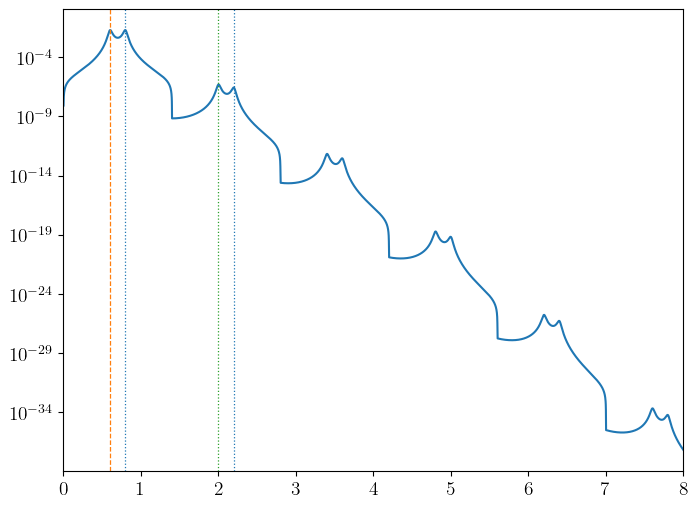

PyObject <matplotlib.lines.Line2D object at 0x7fe69c8b9d90>

In [7]:
ωa = 1.0
η = 0.16
γa = 0.05
ϵ = 0.005
ωd = 1.4

ω_list = range(0.0, 8, 10000)

fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(ω_list, [vacuum_expectation_1h(ω, ωd, ωa, η, γa, ϵ) for ω in ω_list])
ax.plot(ω_list, [vacuum_expectation(ω, ωd, ωa, η, γa, ϵ, 6) for ω in ω_list])

ax.set_yscale("log")
ax.set_xlim(0, ω_list[end])
# ax.set_ylim(1e-8, 1e-3)

ax.axvline(disp_rel_dispersive(ωa, η), linestyle="--", linewidth=0.9, color="C1")
ax.axvline(ωd - disp_rel_dispersive(ωa, η), linestyle=":", linewidth=0.9)
# # ax.axvline(2*disp_rel_dispersive(ωa, η), linestyle="--", linewidth=0.9, color="C1")
# # ax.axvline(ωd - 2*disp_rel_dispersive(ωa, η), linestyle="--", linewidth=0.9)
ax.axvline(ωd + disp_rel_dispersive(ωa, η), linestyle=":", linewidth=0.9, color="C2")
ax.axvline(2*ωd - disp_rel_dispersive(ωa, η), linestyle=":", linewidth=0.9)
# # ax.axvline(2*ωd - 2*disp_rel_dispersive(ωa, η), linestyle=":", linewidth=0.9)
# ax.axvline(2*ωd + disp_rel_dispersive(ωa, η), linestyle=":", linewidth=0.9, color="C2")
# ax.axvline(3*ωd - disp_rel_dispersive(ωa, η), linestyle=":", linewidth=0.9)
# # ax.axvline(3*ωd - 2*disp_rel_dispersive(ωa, η), linestyle=":", linewidth=0.9)
# ax.axvline(3*ωd + disp_rel_dispersive(ωa, η), linestyle=":", linewidth=0.9, color="C2")

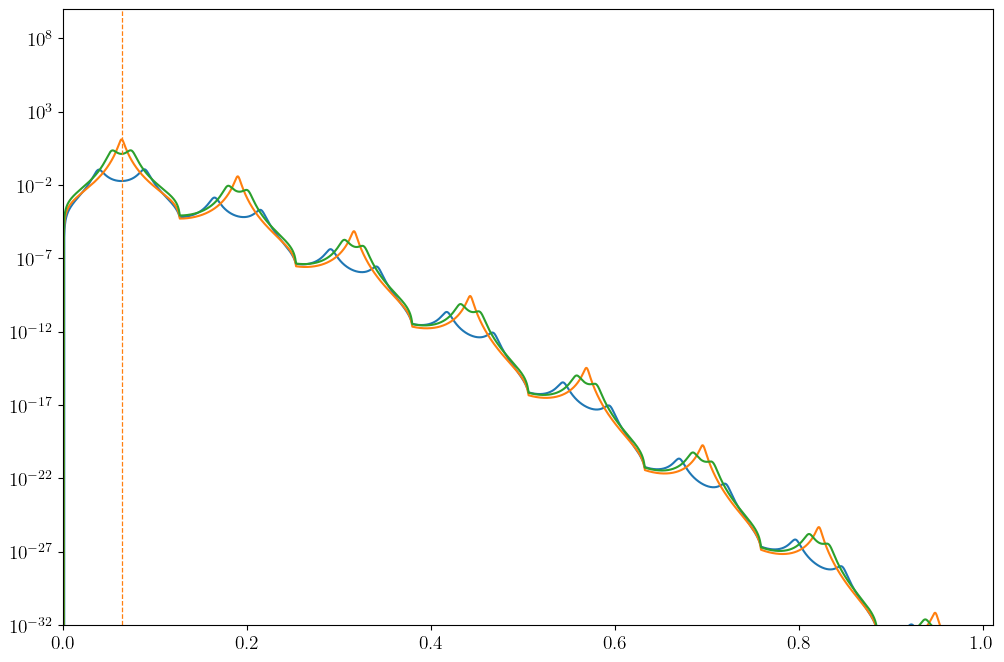

PyObject <matplotlib.lines.Line2D object at 0x7fc622e30810>

In [8]:
η_list_discreta = [0.248, 0.249, 0.2494]
γa = 0.01
ϵ = 0.0005
ωd = disp_rel_dispersive(ωa, 0.249) * 2

upper_bound = 8*ωd
ω_list = range(0.0, upper_bound, 10000)

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(ω_list, [vacuum_expectation(ω, ωd, ωa, η, γa, ϵ, 10) for ω in ω_list, η in η_list_discreta])
# ax.plot(ω_list, [Harmonics(ω, ωd, ωa, η, γa, ϵ, 10) for ω in ω_list, η in η_list_discreta])

ax.set_yscale("log")
ax.set_xlim(0, upper_bound)
ax.set_ylim(1e-32, 1e10)

ax.axvline(disp_rel_dispersive(ωa, 0.249), linestyle="--", linewidth=0.9, color="C1")
# # ax.axvline(2*disp_rel_dispersive(ωa, η), linestyle="--", linewidth=0.9, color="C1")
# # ax.axvline(ωd - 2*disp_rel_dispersive(ωa, η), linestyle="--", linewidth=0.9)
# ax.axvline(ωd - disp_rel_dispersive(ωa, η), linestyle=":", linewidth=0.9)
# ax.axvline(ωd + disp_rel_dispersive(ωa, η), linestyle=":", linewidth=0.9, color="C2")
# ax.axvline(2*ωd - disp_rel_dispersive(ωa, η), linestyle=":", linewidth=0.9)
# # ax.axvline(2*ωd - 2*disp_rel_dispersive(ωa, η), linestyle=":", linewidth=0.9)
# ax.axvline(2*ωd + disp_rel_dispersive(ωa, η), linestyle=":", linewidth=0.9, color="C2")
# ax.axvline(3*ωd - disp_rel_dispersive(ωa, η), linestyle=":", linewidth=0.9)
# # ax.axvline(3*ωd - 2*disp_rel_dispersive(ωa, η), linestyle=":", linewidth=0.9)
# ax.axvline(3*ωd + disp_rel_dispersive(ωa, η), linestyle=":", linewidth=0.9, color="C2")

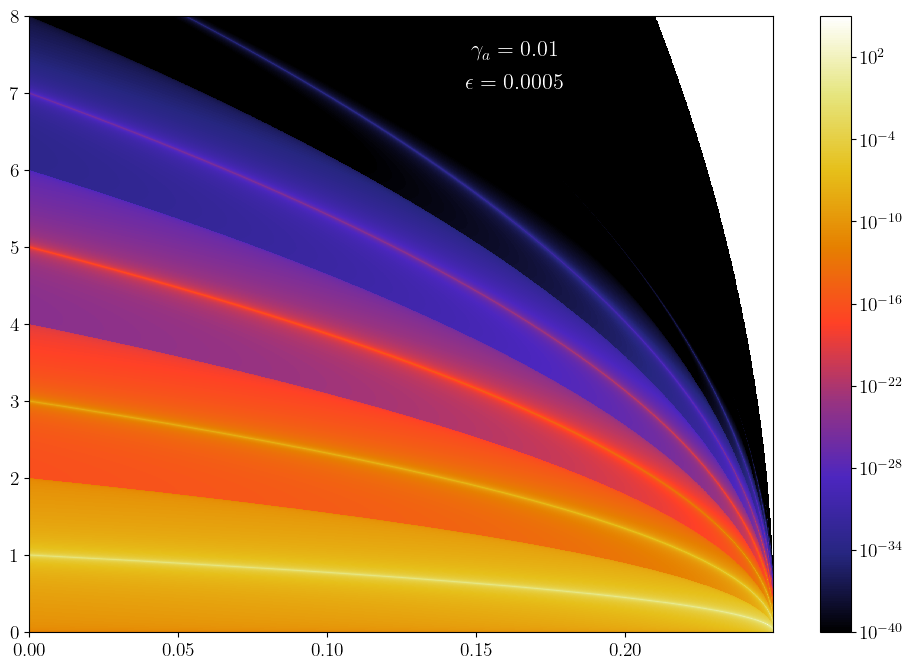

In [27]:
γa = 1e-2
ϵ = 5e-4
n_harmonics = 10

ω_list = range(0.0, 8, 5000)
η_list = range(1e-5, 0.25 - ϵ, 2000)

# Harmonics_spectrum = zeros(Float64, length(ω_list), length(η_list))

# prog = ProgressBar(length(η_list))
# Threads.@threads for i in eachindex(η_list)
#     Harmonics_spectrum[:, i] = [vacuum_expectation_res(ω, ωa, η_list[i], γa, ϵ, n_harmonics) for ω in ω_list]
#     next!(prog)
# end

LogNorm = PyPlot.matplotlib[:colors][:LogNorm]
fig, ax = plt.subplots(figsize=(12, 8))
c = ax.pcolormesh(η_list, ω_list, Harmonics_spectrum, cmap="CMRmap", norm=LogNorm(vmin=1e-40, vmax=1e5), rasterized=true)
cbar = fig.colorbar(c, ax=ax)

fig.text(0.53, 0.83, L"$\gamma_a = 0.01$", ha="center", fontsize=16, color="white")
fig.text(0.53, 0.79, L"$\epsilon = 0.0005$", ha="center", fontsize=16, color="white")

# plt.savefig("Julia/Modulation_Dicke/Dispersive_regime/Harmonics_spectrum.pdf", dpi=300, bbox_inches="tight")

In [19]:
minimum(x for x in Harmonics_spectrum_critical if !isnan(x) && x != 0), maximum(x for x in Harmonics_spectrum_critical if !isnan(x) && x != 0)

(3.1827602226072346e-108, 3589.3158181685153)

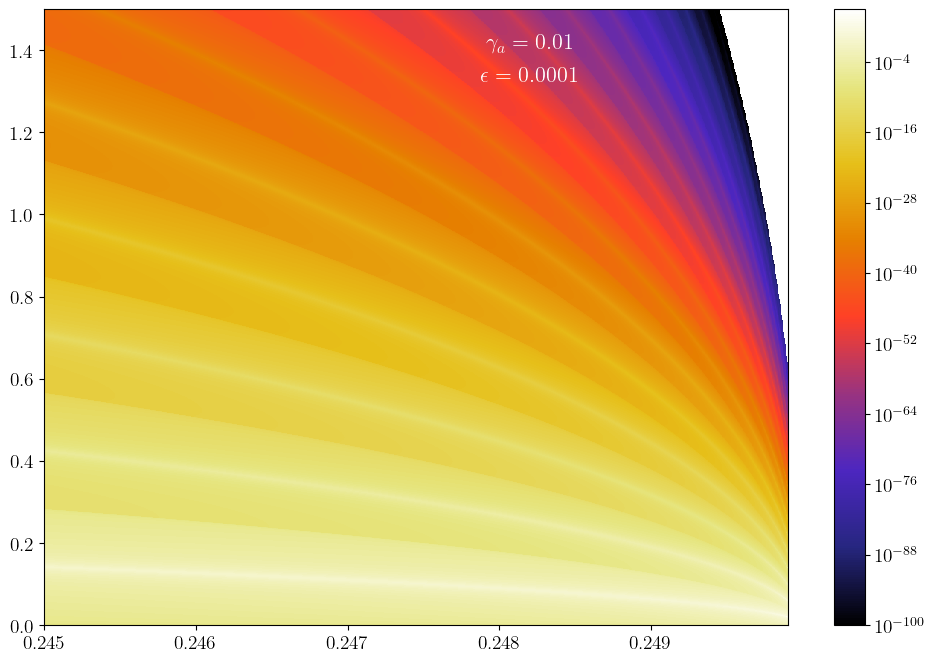

In [ ]:
γa = 1e-2
ϵ = 1e-4
n_harmonics = 16

ω_list = range(0.0, 1.5, 4000)
η_list = range(0.245, 0.25 - ϵ, 1000)

# Harmonics_spectrum_critical = zeros(Float64, length(ω_list), length(η_list))

# prog = ProgressBar(length(η_list))
# Threads.@threads for i in eachindex(η_list)
#     Harmonics_spectrum_critical[:, i] = [vacuum_expectation_res(ω, ωa, η_list[i], γa, ϵ, n_harmonics) for ω in ω_list]
#     next!(prog)
# end

LogNorm = PyPlot.matplotlib[:colors][:LogNorm]
fig, ax = plt.subplots(figsize=(12, 8))
c = ax.pcolormesh(η_list, ω_list, Harmonics_spectrum_critical, cmap="CMRmap", norm=LogNorm(vmin=1e-100, vmax=1e5), rasterized=true)
cbar = fig.colorbar(c, ax=ax)

fig.text(0.53, 0.83, raw"$\gamma_a = 0.01$", ha="center", fontsize=16, color="white")
fig.text(0.53, 0.79, raw"$\epsilon = 0.0001$", ha="center", fontsize=16, color="white")

# plt.savefig("Julia/Modulation_Dicke/Dispersive_regime/Harmonics_spectrum_critical3.pdf", dpi=300, bbox_inches="tight")

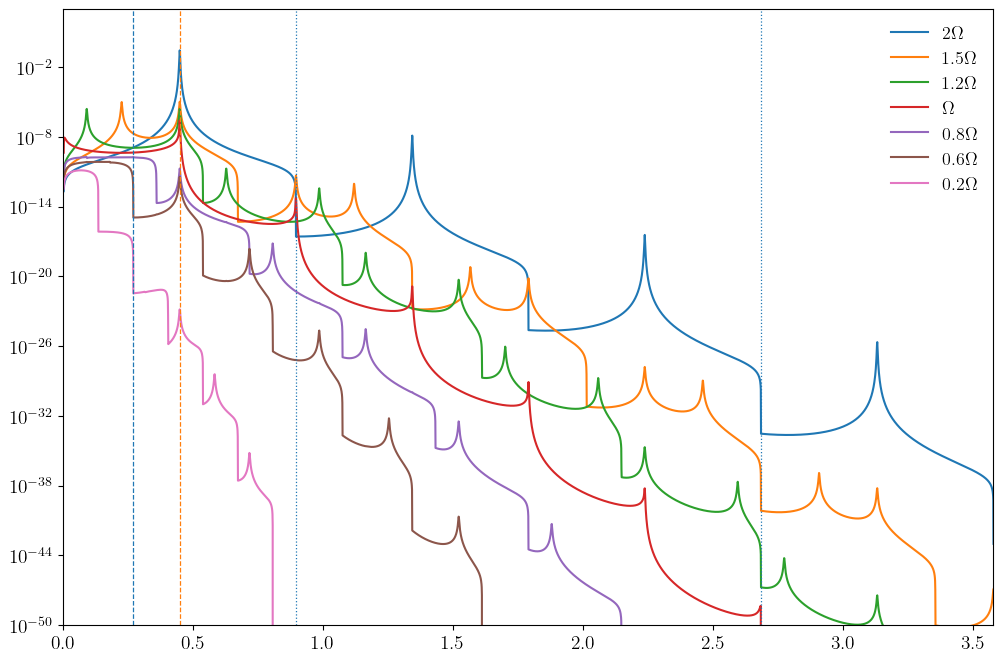

PyObject <matplotlib.legend.Legend object at 0x7f8de9891350>

In [187]:
η = 0.2
# ωd = disp_rel_dispersive(ωa, η) * 2
ω_list = range(0.0, 8, 10000)

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(ω_list, [vacuum_expectation(ω, disp_rel_dispersive(ωa, η) * 2, ωa, η, γa, ϵ, 6) for ω in ω_list], label=raw"$2 \Omega$")
ax.plot(ω_list, [vacuum_expectation(ω, disp_rel_dispersive(ωa, η) * 1.5, ωa, η, γa, ϵ, 6) for ω in ω_list], label=raw"$1.5 \Omega$")
ax.plot(ω_list, [vacuum_expectation(ω, disp_rel_dispersive(ωa, η) * 1.2, ωa, η, γa, ϵ, 6) for ω in ω_list], label=raw"$1.2 \Omega$")
ax.plot(ω_list, [vacuum_expectation(ω, disp_rel_dispersive(ωa, η), ωa, η, γa, ϵ, 6) for ω in ω_list], label=raw"$\Omega$")
ax.plot(ω_list, [vacuum_expectation(ω, disp_rel_dispersive(ωa, η) * 0.8, ωa, η, γa, ϵ, 6) for ω in ω_list], label=raw"$0.8 \Omega$")
ax.plot(ω_list, [vacuum_expectation(ω, disp_rel_dispersive(ωa, η) * 0.6, ωa, η, γa, ϵ, 6) for ω in ω_list], label=raw"$0.6 \Omega$")
# ax.plot(ω_list, [vacuum_expectation(ω, disp_rel_dispersive(ωa, η) * 0.5, ωa, η, γa, ϵ, 6) for ω in ω_list], label=raw"$0.5 \Omega$")
ax.plot(ω_list, [vacuum_expectation(ω, disp_rel_dispersive(ωa, η) * 0.3, ωa, η, γa, ϵ, 6) for ω in ω_list], label=raw"$0.2 \Omega$")

ax.axvline(0.6*disp_rel_dispersive(ωa, η), linestyle="--", linewidth=0.9)
ax.axvline(disp_rel_dispersive(ωa, η), linestyle="--", linewidth=0.9, color="C1")
ax.axvline(2*disp_rel_dispersive(ωa, η), linestyle=":", linewidth=0.9)
ax.axvline(6*disp_rel_dispersive(ωa, η), linestyle=":", linewidth=0.9)

ax.set_xlim(0, 8*disp_rel_dispersive(ωa, η))
ax.set_ylim(1e-50, 1e3)
ax.set_yscale("log")
ax.legend()

### Photon flux

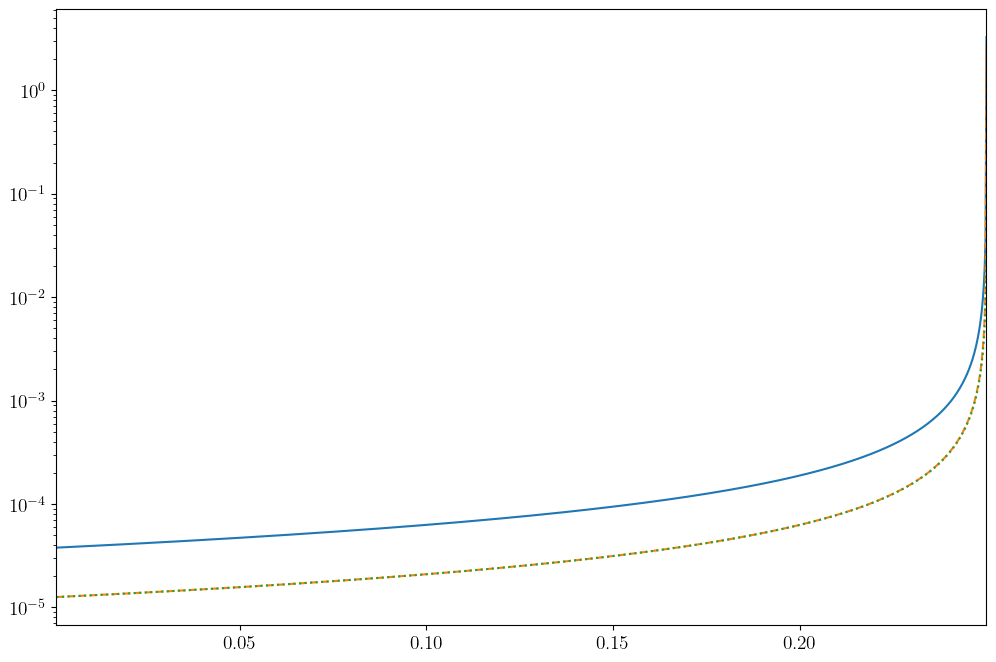

(0.001, 0.2499)

In [ ]:
γa = 0.01
ϵ = 0.0001

η_list = range(1e-3, 0.25 - 1e-4, 1000)

fig, ax = plt.subplots(figsize=(12, 8))

# photon_flux_list = zeros(Float64, length(η_list))
# photon_flux_1h_list = zeros(Float64, length(η_list))
# photon_flux_linear_list = zeros(Float64, length(η_list))

# prog = ProgressBar(length(η_list))
# Threads.@threads for i in eachindex(η_list)
#     # photon_flux_list[i] = photon_flux_res(25000, 10*disp_rel_dispersive(ωa, η_list[i]), ωa, η_list[i], γa, ϵ, 8)
#     photon_flux_list[i] = photon_flux_res(10000, 16*disp_rel_dispersive(ωa, η_list[i]), ωa, η_list[i], γa, ϵ, 10)
#     # photon_flux_list[i] = photon_flux_res(600, 6*disp_rel_dispersive(ωa, η_list[i]), ωa, η_list[i], γa, ϵ, 5)
#     photon_flux_1h_list[i] = photon_flux_1h_res(1000, 2*disp_rel_dispersive(ωa, η_list[i]), ωa, η_list[i], γa, ϵ)
#     photon_flux_linear_list[i] = photon_flux_linear_res(1000, 2*disp_rel_dispersive(ωa, η_list[i]), ωa, η_list[i], γa, ϵ)
#     next!(prog)
# end

ax.plot(η_list, photon_flux_list, label=raw"$10$ harmonics")
ax.plot(η_list, photon_flux_1h_list, linestyle="--", label=raw"$1$ harmonic")
ax.plot(η_list, photon_flux_linear_list, linestyle=":", label=raw"$\text{linear}$")

ax.set_yscale("log")
ax.set_xlim(η_list[1], η_list[end])

Progress: [==============================] 100.0% --- Elapsed Time: 0h 04m 00s (ETA: 0h 00m 00s)


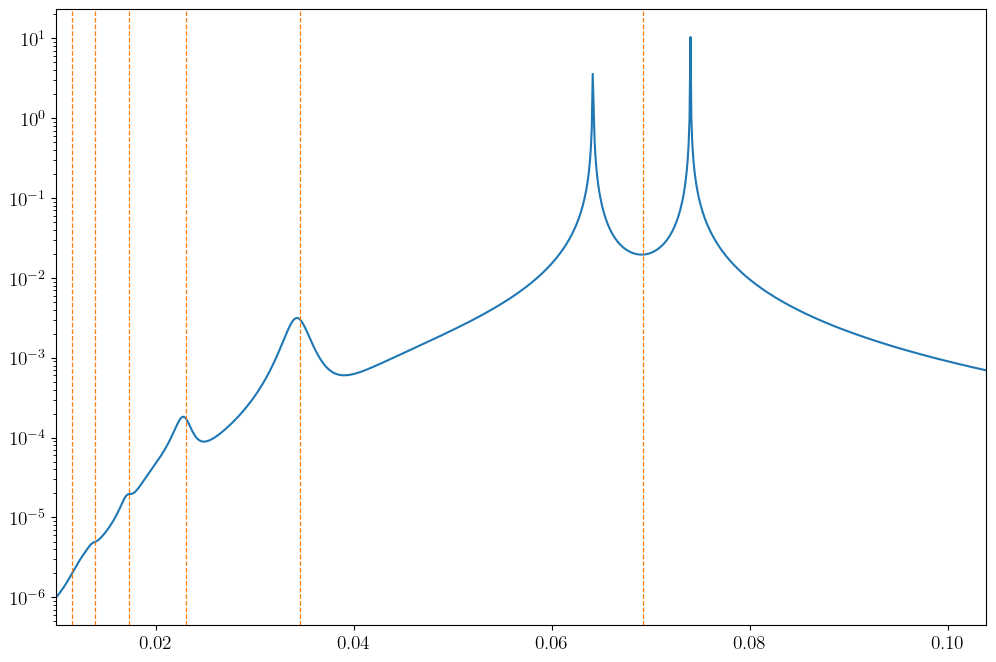

(0.01, 0.10392304845413172)

In [ ]:
γa = 0.003
ϵ = 0.0001
η = 0.2497

ωd_list = range(0.01, 3*disp_rel_dispersive(ωa, η), 1000)

photon_flux_list_ωd = zeros(Float64, length(ωd_list))

prog = ProgressBar(length(ωd_list))
Threads.@threads for i in eachindex(ωd_list)
    photon_flux_list_ωd[i] = photon_flux(12000, 12*ωd_list[i], ωd_list[i], ωa, η, γa, ϵ, 8)
    next!(prog)
end

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(ωd_list, photon_flux_list_ωd)
ax.axvline(disp_rel_dispersive(ωa, η)*2/6, linestyle="--", linewidth=0.9, color="C1")
ax.axvline(disp_rel_dispersive(ωa, η)*2/5, linestyle="--", linewidth=0.9, color="C1")
ax.axvline(disp_rel_dispersive(ωa, η)*2/4, linestyle="--", linewidth=0.9, color="C1")
ax.axvline(disp_rel_dispersive(ωa, η)*2/3, linestyle="--", linewidth=0.9, color="C1")
ax.axvline(disp_rel_dispersive(ωa, η), linestyle="--", linewidth=0.9, color="C1")
ax.axvline(disp_rel_dispersive(ωa, η)*2, linestyle="--", linewidth=0.9, color="C1")

ax.set_yscale("log")
ax.set_xlim(ωd_list[1], ωd_list[end])
# ax.set_ylim(0, maximum(photon_number_list)*1.05)

In [ ]:
# γa = 0.001
# ϵ = 0.0001
η_list_discreta = [0.1, 0.2, 0.22, 0.24, 0.245, 0.249, 0.2494]

ωd_list = range(0.01, 3*disp_rel_dispersive(ωa, η_list_discreta[1]), 1000)

# pippo1 = zeros(Float64, length(ωd_list))
# pippo2 = zeros(Float64, length(ωd_list))
# pippo4 = zeros(Float64, length(ωd_list), length(η_list_discreta))

prog = ProgressBar(length(ωd_list))
Threads.@threads for i in eachindex(ωd_list)
    for η in eachindex(η_list_discreta)
        # pippo1[i] = photon_number(0.0, 6, ωd_list[i], ωa, η_list_discreta[η], γa, ϵ, 5, 1e-8)
        # pippo2[i] = photon_number_fast(30000, 6, ωd_list[i], ωa, η_list_discreta[η], γa, ϵ, 8)
        pippo4[i, η] = photon_number_fast(20000, 6*ωd_list[i], ωd_list[i], ωa, η_list_discreta[η], γa, ϵ, 8)
    end
    next!(prog)
end

# pippo1 = [photon_number(0.0, 6, ωd, ωa, η, γa, ϵ, 5, 1e-10) for ωd in ωd_list]
# pippo2 = [photon_number(0.0, 10, ωd, ωa, 0.15, γa, 2e-5, 3) for ωd in ωd_list]

fig, ax = plt.subplots(figsize=(12, 8))

# ax.plot(ωd_list, pippo1)
# ax.plot(ωd_list, pippo2)
ax.plot(ωd_list, pippo4)
# ax.axvline(disp_rel_dispersive(ωa, η)*2/6, linestyle="--", linewidth=0.9, color="C1")
# ax.axvline(disp_rel_dispersive(ωa, η)*2/5, linestyle="--", linewidth=0.9, color="C1")
# ax.axvline(disp_rel_dispersive(ωa, η)*2/4, linestyle="--", linewidth=0.9, color="C1")
# ax.axvline(disp_rel_dispersive(ωa, η)*2/3, linestyle="--", linewidth=0.9, color="C1")
# ax.axvline(disp_rel_dispersive(ωa, η), linestyle="--", linewidth=0.9, color="C1")
# ax.axvline(disp_rel_dispersive(ωa, η)*2, linestyle="--", linewidth=0.9, color="C1")

ax.set_yscale("log")
ax.set_xlim(ωd_list[1], ωd_list[end])
# ax.set_xlim(0, 0.5)
# ax.set_ylim(0, maximum(photon_number_list)*1.05)

LoadError: UndefVarError: `pippo4` not defined

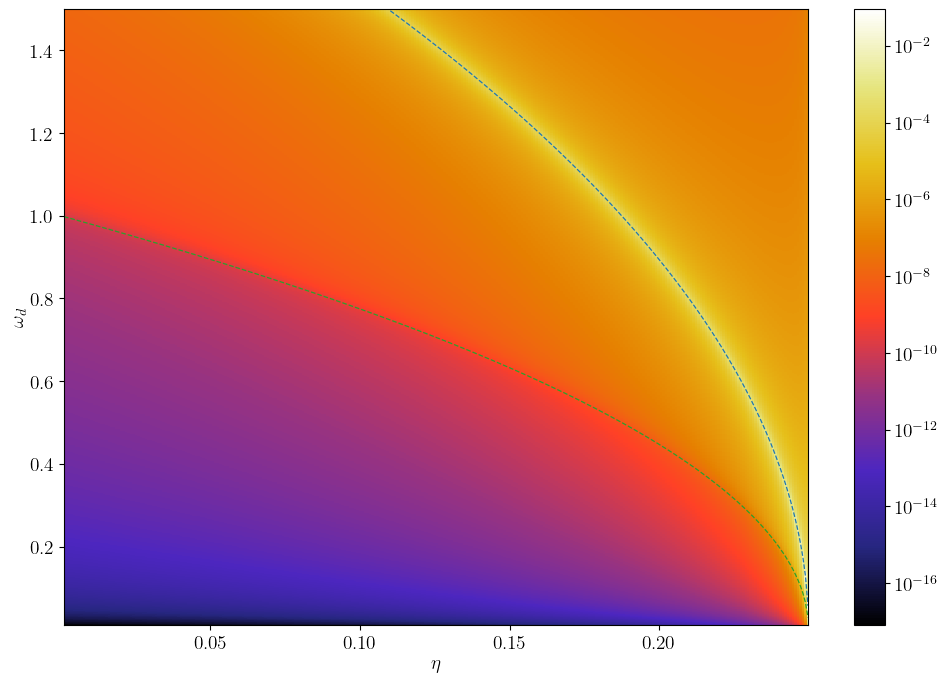

PyObject Text(27.219312263257585, 0.5, '$\\omega_d$')

In [102]:
# γa = 0.001
# ϵ = 0.0001

ωd_list = range(0.01, 1.5, 1000)
η_list = range(1e-3, 0.25 - 2*ϵ, 300)

# photon_flux_spectrum = zeros(Float64, length(ωd_list), length(η_list))

# prog = ProgressBar(length(η_list))
# Threads.@threads for i in eachindex(η_list)
#     photon_flux_spectrum[:, i] = [photon_flux(3000, 5*ωd, ωd, ωa, η_list[i], γa, ϵ, 6) for ωd in ωd_list]
#     next!(prog)
# end

fig, ax = plt.subplots(figsize=(12, 8))

LogNorm = PyPlot.matplotlib[:colors][:LogNorm]
c = ax.pcolormesh(η_list, ωd_list, photon_flux_spectrum, cmap="CMRmap", norm=LogNorm(vmin=minimum(photon_flux_spectrum), vmax=maximum(photon_flux_spectrum)), rasterized=true)
cbar = fig.colorbar(c, ax=ax)
ax.set_xlim(η_list[1], η_list[end])
ax.set_ylim(ωd_list[1], ωd_list[end])

ax.plot(η_list, [2*disp_rel_dispersive(ωa, η) for η in η_list], color="C0", linestyle="--", linewidth=0.9)
ax.plot(η_list, [disp_rel_dispersive(ωa, η) for η in η_list], color="C2", linestyle="--", linewidth=0.9)

ax.set_xlabel(raw"$\eta$")
ax.set_ylabel(raw"$\omega_d$")

# plt.savefig("Julia/Modulation_Dicke/Dispersive_regime/photon_flux_spectrum_lines.pdf", dpi=300, bbox_inches="tight")

In [ ]:
γa = 0.001
ϵ = 0.0005

ωd_list = range(0.01, 0.3, 1000)
η_list = range(0.245, 0.25 - 1.1*ϵ, 1000)

photon_flux_spectrum_critical = zeros(Float64, length(ωd_list), length(η_list))

prog = ProgressBar(length(η_list))
Threads.@threads for i in eachindex(η_list)
    photon_flux_spectrum_critical[:, i] = [photon_flux(15000, 11*ωd, ωd, ωa, η_list[i], γa, ϵ, 12) for ωd in ωd_list]
    next!(prog)
end

fig, ax = plt.subplots(figsize=(12, 8))

LogNorm = PyPlot.matplotlib[:colors][:LogNorm]
c = ax.pcolormesh(η_list, ωd_list, photon_flux_spectrum_critical, cmap="CMRmap", norm=LogNorm(vmin=minimum(photon_flux_spectrum_critical), vmax=maximum(photon_flux_spectrum_critical)), rasterized=true)
cbar = fig.colorbar(c, ax=ax)
ax.set_xlim(η_list[1], η_list[end])
ax.set_ylim(ωd_list[1], ωd_list[end])

ax.plot(η_list, [2*disp_rel_dispersive(ωa, η) for η in η_list], color="C0", linestyle="--", linewidth=0.9)
ax.plot(η_list, [disp_rel_dispersive(ωa, η) for η in η_list], color="C0", linestyle="--", linewidth=0.9)
ax.plot(η_list, [2/3*disp_rel_dispersive(ωa, η) for η in η_list], color="C0", linestyle="--", linewidth=0.9)

ax.set_xlabel(raw"$\eta$")
ax.set_ylabel(raw"$\omega_d$")

# plt.savefig("Julia/Modulation_Dicke/Dispersive_regime/photon_flux_spectrum_critical_bifurcation.pdf", dpi=300, bbox_inches="tight")
# jldsave("Julia/Modulation_Dicke/Dispersive_regime/photon_flux_spectrum_critical_bifurcation.jld2"; γa, ϵ, η_list, ωd_list, photon_flux_spectrum_critical)
# # suca = jldopen("Julia/Modulation_Dicke/Dispersive_regime/photon_flux_spectrum_critical_bifurcation.jld2", "r") 

Progress: [=====================         ]  70.9% --- Elapsed Time: 164h 27m 26s (ETA: 67h 29m 57s))

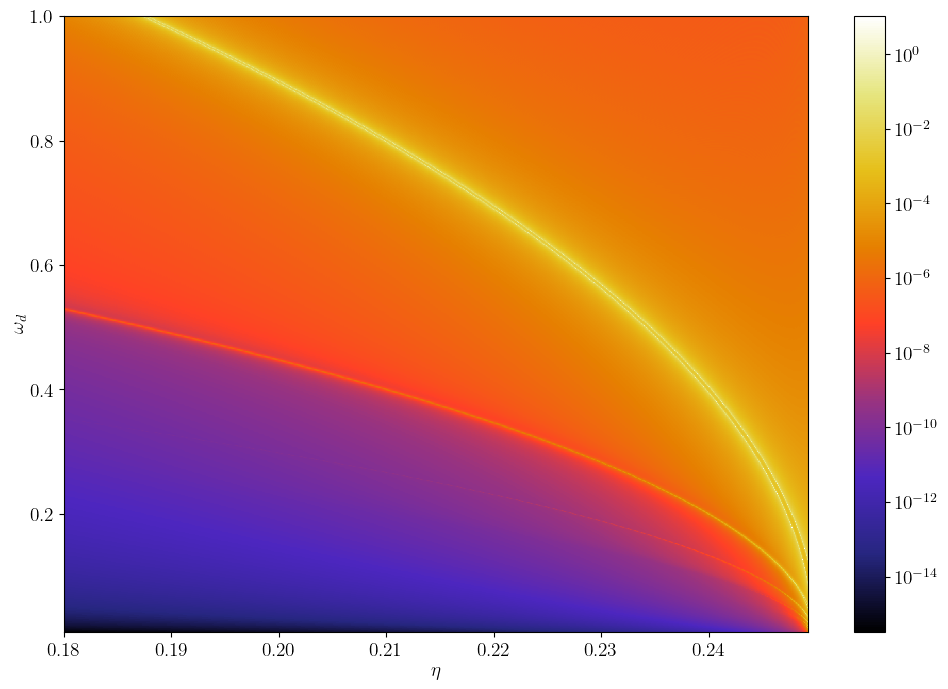

PyObject Text(27.219312263257585, 0.5, '$\\omega_d$')

In [ ]:
γa = 0.001
ϵ = 0.0005

ωd_list = range(0.01, 1, 900)
η_list = range(0.18, 0.25 - 1.5*ϵ, 700)

# photon_flux_spectrum_critical2 = zeros(Float64, length(ωd_list), length(η_list))

# prog = ProgressBar(length(η_list))
# Threads.@threads for i in eachindex(η_list)
#     photon_flux_spectrum_critical2[:, i] = [photon_flux(6000, 9*ωd, ωd, ωa, η_list[i], γa, ϵ, 10) for ωd in ωd_list]
#     next!(prog)
# end

fig, ax = plt.subplots(figsize=(12, 8))

LogNorm = PyPlot.matplotlib[:colors][:LogNorm]
c = ax.pcolormesh(η_list, ωd_list, photon_flux_spectrum_critical2, cmap="CMRmap", norm=LogNorm(vmin=minimum(photon_flux_spectrum_critical2), vmax=maximum(photon_flux_spectrum_critical2)), rasterized=true)
cbar = fig.colorbar(c, ax=ax)
ax.set_xlim(η_list[1], η_list[end])
ax.set_ylim(ωd_list[1], ωd_list[end])

# ax.plot(η_list, [2*disp_rel_dispersive(ωa, η) for η in η_list], color="C0", linestyle="--", linewidth=0.9)
# ax.plot(η_list, [disp_rel_dispersive(ωa, η) for η in η_list], color="C0", linestyle="--", linewidth=0.9)
# ax.plot(η_list, [2/3*disp_rel_dispersive(ωa, η) for η in η_list], color="C0", linestyle="--", linewidth=0.9)

ax.set_xlabel(raw"$\eta$")
ax.set_ylabel(raw"$\omega_d$")

# plt.savefig("Julia/Modulation_Dicke/Dispersive_regime/photon_flux_spectrum_critical_bifurcation2.pdf", dpi=300, bbox_inches="tight")
# jldsave("Julia/Modulation_Dicke/Dispersive_regime/photon_flux_spectrum_critical_bifurcation2.jld2"; γa, ϵ, η_list, ωd_list, photon_flux_spectrum_critical2)

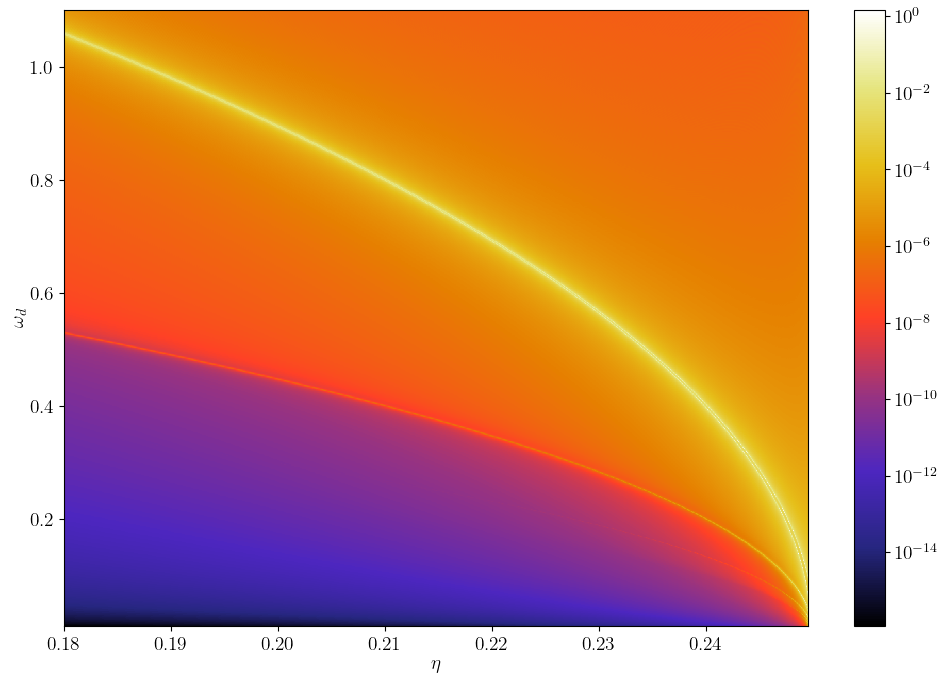

In [ ]:
γa = 0.001
ϵ = 0.0003

ωd_list = range(0.01, 1.1, 900)
η_list = range(0.18, 0.25 - 1.5*ϵ, 700)

# photon_flux_spectrum_critical3 = zeros(Float64, length(ωd_list), length(η_list))

# prog = ProgressBar(length(η_list))
# Threads.@threads for i in eachindex(η_list)
#     photon_flux_spectrum_critical3[:, i] = [photon_flux(6000, 8*ωd, ωd, ωa, η_list[i], γa, ϵ, 9) for ωd in ωd_list]
#     next!(prog)
# end

fig, ax = plt.subplots(figsize=(12, 8))

LogNorm = PyPlot.matplotlib[:colors][:LogNorm]
c = ax.pcolormesh(η_list, ωd_list, photon_flux_spectrum_critical3, cmap="CMRmap", norm=LogNorm(vmin=minimum(photon_flux_spectrum_critical3), vmax=maximum(photon_flux_spectrum_critical3)), rasterized=true)
cbar = fig.colorbar(c, ax=ax)
ax.set_xlim(η_list[1], η_list[end])
ax.set_ylim(ωd_list[1], ωd_list[end])

# ax.plot(η_list, [2*disp_rel_dispersive(ωa, η) for η in η_list], color="C0", linestyle="--", linewidth=0.9)
# ax.plot(η_list, [disp_rel_dispersive(ωa, η) for η in η_list], color="C0", linestyle="--", linewidth=0.9)
# ax.plot(η_list, [2/3*disp_rel_dispersive(ωa, η) for η in η_list], color="C0", linestyle="--", linewidth=0.9)

ax.set_xlabel(raw"$\eta$")
ax.set_ylabel(raw"$\omega_d$")

# plt.savefig("Julia/Modulation_Dicke/Dispersive_regime/photon_flux_spectrum_critical_bifurcation3.pdf", dpi=300, bbox_inches="tight")
# jldsave("Julia/Modulation_Dicke/Dispersive_regime/photon_flux_spectrum_critical_bifurcation3.jld2"; γa, ϵ, η_list, ωd_list, photon_flux_spectrum_critical3)